<a href="https://colab.research.google.com/github/jadercaro/Prediccion-de-desercion-universitaria/blob/main/1_Preprocesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargamos la base de datos y Librerias

In [ ]:
!pip install pycaret

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

from pycaret.classification import *

warnings.filterwarnings('ignore')
!git clone https://github.com/jadercaro/Prediccion-de-desercion-universitaria
os.chdir('/content/Prediccion-de-desercion-universitaria/dataset')

Cargamos la base de datos

In [4]:
df = pd.read_csv('datos1.csv')

# Transformación de variables

## Exclusión de variables
Esta exclusión se hace basada en la matriz de correlación


| No. | Comparación                                            | Correlación | Target  | Resultado |
|-----|--------------------------------------------------------|-------------|---------|-----------|
| 1   | Credited 1 ➡ Enrolled 1 : Credited 2        | 0.77 : 0.94       | 0.029    | Eliminar🔴       |
| 2   | Enrolled 1 ➡ Credited 1 : Approved 1 : Credited 2 : Enrolled 2             | 0.77 : 0.77 : 0.75 : 0.94 | 0.124    | Eliminar🔴       |
| 3   | Evaluations 1 ➡ Evaluations 2          | 0.78        | 0.090   | Eliminar🔴       |
| 4   | Approved 1 ➡ Approved 2 : Enrolled 1                 | 0.9 : 0.77         | 0.480    | Conservar🟢        |
| 5   | Grade 1 ➡ Grade 2                      | 0.84        | 0.480    |   Eliminar🔴         |
| 6   | Credited 2 ➡ Credited 1 : Enrolled 1             | 0.94        | 0.033   | Conservar🟢          |
| 7   | Enrolled 2 ➡ Enrolled 1                | 0.94        | 0.141    | Conservar🟢          |
| 8   | Evaluations 2 ➡ Evaluations 1          | 0.78        | 0.154   | Conservar🟢          |
| 9   | Approved 2 ➡ Approved 1 : Grade 2               | 0.9 : 0.76         | 0.569   | Eliminar🔴         |
| 10  | Grade 2 ➡ Grade 1 : Approved 2                   | 0.84 : 0.76        | 0.571   | Conservar🟢       |
| 11  | Daytime/evening attendance ➡ Course                    | 0.998       | 0.078   | Eliminar🔴         |
| 12  | Course ➡ Daytime/evening attendance                    | 0.998       | 0.253   | Conservar🟢          |
| 13  | Nationality ➡ International                            | 0.998       | 0.000   | Eliminar🔴         |
| 14  | International ➡ Nationality                            | 0.998       | 0.000   | Eliminar🔴         |
| 15  | Educational special needs                            | -      | 0.000   | Eliminar🔴         |


In [5]:
df = df.drop(columns=['Curricular units 1st sem (credited)','Curricular units 1st sem (enrolled)',
                      'Curricular units 1st sem (evaluations)','Curricular units 1st sem (grade)',
                      'Curricular units 2nd sem (approved)','Daytime/evening attendance\t',
                      'Nacionality','Educational special needs',
                      'International'])

## Codificación de las variables categóricas
Usaremos el método de codificación One Hot Encoding para las variables catégoricas que tengan más de dos catégorias

In [6]:
variables_codificar = ['Marital status', 'Application mode', 'Application order', 'Course',
                       'Previous qualification','''Mother's qualification''', '''Father's qualification''',
                      '''Mother's occupation''', '''Father's occupation''']

encoder = OneHotEncoder(sparse_output=False)

# Ajustar y transformar las columnas categóricas
encoded_data = encoder.fit_transform(df[variables_codificar])


# Crear un DataFrame con las columnas codificadas
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(variables_codificar))

#Convertimos las variables a tipo bool
encoded_df=encoded_df.astype(bool)

# Concatenar el DataFrame original con el DataFrame codificado
final_df = pd.concat([df, encoded_df], axis=1)

#Eliminamos las columnas ya co
final_df = final_df.drop(columns=variables_codificar)

## Convertimos las variables Booleanas a tipo Bool

In [7]:
columnas_bool = ['Displaced','Debtor','Tuition fees up to date', 'Gender','Scholarship holder', 'Target']
final_df[columnas_bool] = final_df[columnas_bool].astype(bool)

## Escalamientos de variables númericas
Elimina la media, media = 0, y varianza = 1, se hace esto para obtener mejor rendimiento en los modelos, se debe tener cuidado en la interpretación de los resultados obtenidos

In [8]:
var_estandarizar = final_df.select_dtypes(exclude=bool).columns

# Crea un objeto StandardScaler
scaler = StandardScaler()

# Ajusta el scaler a las columnas seleccionadas y luego transforma las columnas
columnas_escaladas = scaler.fit_transform(final_df[var_estandarizar])

# Reemplaza las columnas originales con las columnas escaladas
final_df[var_estandarizar] = columnas_escaladas

## Balanceo de clases
Primero analizaremos el desembalance de clase para saber la proporción y luego hacer el submuestreo y el sobremuestreo, luego haremos una validación basandones en el rendimiento de varios modelos para determinar con cuales datos de entrenamiento nos quedaremos

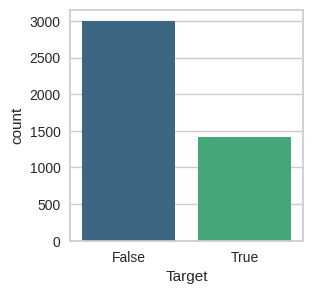

In [9]:
plt.figure(figsize=(3,3))
sns.countplot(data=final_df,x='Target', palette ='viridis')
plt.show()

In [8]:
Counter(final_df['Target'])

Counter({True: 1421, False: 3003})

Se evidencia que hay un desbalance aproximado de 1:2 por ende optaremos por acudir a métodos de submuestreo y sobremuestreo

## Base de datos sobremuestreada
Para este proceso lo primero que haremos será sobremuestrearlas, usaremos el método SMOTE (Syntetic Minority Over-sampling Tecnique)

In [10]:
#Separamos los datos de entrenamiento de validación para solo aplicar las técnicas de balanceo a las muestras de entrenamiento
x_train,x_test,y_train,y_test = train_test_split(final_df.drop(columns='Target'),final_df['Target'], stratify= final_df['Target'], test_size=0.2, random_state=5)

#Creamos la instancia de SMOTE y aplicamos el sobremuestreo
sm = SMOTE(random_state= 4)
x_over,y_over=sm.fit_resample(x_train,y_train)

#Mostramos la distribución con el sobremuestreo
print(Counter(y_over))

Counter({False: 2402, True: 2402})


###Rendimiento con sobremuestreo - SMOTE
Lo que se hace a continuación es entrenar distintos modelos para conocer que tan bien el modelo es capaz de predecir las clases usando las muestras sobremuestreadas, esto lo haremos con la ayuda de la librería pycaret, la cuál usa 15 modelos distintos con parámetros predeterminados, nuestra decisión la basaremos la base de datos que muestre mejor desempeño en el F1-score, ya que necesitamos un equilibrio entre la Precisión y el Recall

In [21]:
#Creamos los modelos con la base de datos sobremuestreada
model_over = setup(data = pd.concat([x_over,y_over],axis=1),target='Target', fold=5, normalize=False)

#Mostramos los resultados de los modelos
best_models_over = model_over.compare_models()

,Description,Value
0,Session id,5984
1,Target,Target
2,Target type,Binary
3,Original data shape,"(4804, 226)"
4,Transformed data shape,"(4804, 226)"
5,Transformed train set shape,"(3362, 226)"
6,Transformed test set shape,"(1442, 226)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9018,0.9535,0.8679,0.9314,0.8983,0.8037,0.8059,1.5800
et,Extra Trees Classifier,0.8980,0.9585,0.8774,0.9153,0.8957,0.7960,0.7971,0.9860
ridge,Ridge Classifier,0.8876,0.9511,0.8316,0.9366,0.8808,0.7751,0.7803,0.1580
rf,Random Forest Classifier,0.8876,0.9555,0.8644,0.9064,0.8847,0.7751,0.7763,1.0100
lightgbm,Light Gradient Boosting Machine,0.8870,0.9546,0.8709,0.9002,0.8849,0.7739,0.7750,0.9840
lda,Linear Discriminant Analysis,0.8843,0.9487,0.8293,0.9322,0.8775,0.7686,0.7736,0.2500
xgboost,Extreme Gradient Boosting,0.8843,0.9516,0.8661,0.8992,0.8819,0.7686,0.7698,0.8800
gbc,Gradient Boosting Classifier,0.8804,0.9470,0.8649,0.8929,0.8783,0.7608,0.7619,2.5960
svm,SVM - Linear Kernel,0.8736,0.9408,0.8786,0.8712,0.8743,0.7472,0.7483,0.1860
ada,Ada Boost Classifier,0.8667,0.9369,0.8566,0.8747,0.8653,0.7335,0.7340,0.5700


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

### Validación con muestra de testeo - Sobremuestreo


In [23]:
y_pred=best_models_over.predict(x_test)

pd.DataFrame({"Precision":[precision_score(y_test,y_pred)],
              "Recall":[recall_score(y_test,y_pred)],
              "F1-Score":[f1_score(y_test,y_pred)],
              "AUC":[auc(y_test,y_pred)]})

,Precision,Recall,F1-Score,AUC
0,0.814961,0.728873,0.769517,142.5


## Base de datos submuestreada
Para este proceso lo primero que haremos será submuestrearla, usaremos el método RepeatedEditedNearestNeighbours, lo que hace este método es análizar todas las muestras mayoritarias y obtener sus 3 vecinos más cercanos, si la mayoria de estos vecinos pertenecen a la clase minoritaria esta muestra de la clase mayoritaria es descartada, esto propicia una mejor distinción entre la clase positiva (desertor) y la clase negativa (no desertor),a la vez que reduce el desbalance. Este proceso lo repite varias veces, hasta que no se eliminen más muestras en alguna iteración, hasta que la clase mayoritaria pase a ser minoritaria o hasta que alcance el máximo de iteraciones (100 en nuestro caso).

In [12]:
#Creamos la instancia, le indicamos que solo busque los NN de la clase mayoritaria y máximo 100 iteraciones
renn = RepeatedEditedNearestNeighbours(sampling_strategy='majority', max_iter=100)

#Submuestreamos con los datos de entrenamiento
x_sub, y_sub = renn.fit_resample(x_train, y_train)

#Observamos como quedo la distribución de clases
Counter(y_sub)

Counter({False: 1387, True: 1137})

###Rendimiento con submuestreo -  RepeatedEditedNearestNeighbours
Lo que se hace a continuación es entrenar distintos modelos para conocer que tan bien el modelo es capaz de predecir las clases usando las muestras submuestreadas, esto lo haremos con la ayuda de la librería pycaret, la cuál usa 15 modelos distintos con parámetros predeterminados, nuestra decisión la basaremos la base de datos que muestre mejor desempeño en el F1-score, ya que necesitamos un equilibrio entre la Precisión y el Recall

In [24]:
#Creamos los modelos con la base de datos submuestreada
model_sub = setup(data = pd.concat([x_sub,y_sub],axis=1),target='Target', fold=5, normalize=False)

#Mostramos los resultados de los modelos
best_models_sub = model_sub.compare_models()

,Description,Value
0,Session id,3856
1,Target,Target
2,Target type,Binary
3,Original data shape,"(2524, 226)"
4,Transformed data shape,"(2524, 226)"
5,Transformed train set shape,"(1766, 226)"
6,Transformed test set shape,"(758, 226)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9072,0.9554,0.8631,0.9259,0.8933,0.8113,0.8131,0.3840
lightgbm,Light Gradient Boosting Machine,0.9054,0.9592,0.8556,0.9296,0.8907,0.8077,0.8102,0.4920
rf,Random Forest Classifier,0.9026,0.9569,0.8405,0.9370,0.8861,0.8015,0.8052,0.5700
lr,Logistic Regression,0.9009,0.9522,0.8581,0.9173,0.8863,0.7987,0.8006,1.2220
gbc,Gradient Boosting Classifier,0.8992,0.9535,0.8493,0.9209,0.8835,0.7950,0.7972,1.1700
et,Extra Trees Classifier,0.8981,0.9555,0.8367,0.9300,0.8807,0.7922,0.7958,0.7300
ada,Ada Boost Classifier,0.8953,0.9493,0.8568,0.9058,0.8805,0.7874,0.7885,1.0160
ridge,Ridge Classifier,0.8862,0.9474,0.8066,0.9321,0.8646,0.7674,0.7735,0.0980
svm,SVM - Linear Kernel,0.8771,0.9419,0.8731,0.8585,0.8650,0.7523,0.7535,0.1240
lda,Linear Discriminant Analysis,0.8754,0.9436,0.7953,0.9177,0.8520,0.7454,0.7513,0.2140


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

### Validación con muestra de testeo - Submuestreo

In [25]:
y_pred=best_models_sub.predict(x_test)

pd.DataFrame({"Precision":[precision_score(y_test,y_pred)],
              "Recall":[recall_score(y_test,y_pred)],
              "F1-Score":[f1_score(y_test,y_pred)],
              "AUC":[auc(y_test,y_pred)]})

,Precision,Recall,F1-Score,AUC
0,0.65812,0.81338,0.727559,196.5


## Base de datos desbalanceada
Lo siguiente que haremos será tomar la muestra de entrenamiento desbalanceada la cuál fue separada con el método estratificado para que al momento de entrenar se conserve la misma relación que la original

In [14]:
#Creamos los modelos con la base de datos submuestreada
model_desb = setup(data = pd.concat([x_train,y_train],axis=1),target='Target', fold=5, normalize=False)

#Mostramos los resultados de los modelos
best_models_desb = model_desb.compare_models()

,Description,Value
0,Session id,1629
1,Target,Target
2,Target type,Binary
3,Original data shape,"(3539, 226)"
4,Transformed data shape,"(3539, 226)"
5,Transformed train set shape,"(2477, 226)"
6,Transformed test set shape,"(1062, 226)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8765,0.9091,0.7223,0.8716,0.7891,0.7030,0.7098,0.1340
gbc,Gradient Boosting Classifier,0.8708,0.9060,0.7211,0.8540,0.7813,0.6907,0.6961,1.2500
lightgbm,Light Gradient Boosting Machine,0.8676,0.9003,0.7186,0.8466,0.7770,0.6837,0.6887,0.3700
ridge,Ridge Classifier,0.8652,0.9086,0.6620,0.8902,0.7584,0.6679,0.6826,0.1160
rf,Random Forest Classifier,0.8587,0.9008,0.6696,0.8593,0.7524,0.6558,0.6659,0.5440
ada,Ada Boost Classifier,0.8583,0.8998,0.7135,0.8233,0.7634,0.6631,0.6674,0.3480
xgboost,Extreme Gradient Boosting,0.8583,0.8964,0.7060,0.8280,0.7617,0.6618,0.6664,0.4300
lda,Linear Discriminant Analysis,0.8575,0.9030,0.6607,0.8637,0.7479,0.6512,0.6630,0.1300
et,Extra Trees Classifier,0.8571,0.8990,0.6633,0.8610,0.7490,0.6514,0.6625,0.5500
svm,SVM - Linear Kernel,0.8502,0.8936,0.7034,0.8102,0.7499,0.6441,0.6499,0.1720


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

### Validación con muestra de testeo - Desbalanceada

In [26]:
y_pred=best_models_desb.predict(x_test)

pd.DataFrame({"Precision":[precision_score(y_test,y_pred)],
              "Recall":[recall_score(y_test,y_pred)],
              "F1-Score":[f1_score(y_test,y_pred)],
              "AUC":[auc(y_test,y_pred)]})

,Precision,Recall,F1-Score,AUC
0,0.811475,0.697183,0.75,139.0


#Conclusión
Usaremos la muestra con la los modelos evaluados tuvieron mejor desempeño al momento de distinguir la clase positiva (RECALL), por ende trabajaremos con los datos submuestreados con el método de RepeatedEditedNearestNeighbours.

In [31]:
datos_entrenamiento = pd.concat([x_sub,y_sub],axis=1)
datos_validacion = pd.concat([x_test,y_test],axis=1)

#Descargamos los datos preprocesados
datos_entrenamiento.to_csv('data_train.csv', index=False)
datos_validacion.to_csv('data_test.csv', index=False)